In [47]:
# Check if GPU is mounted

import torch
x = torch.cuda.is_available()
print(x)

True


In [ ]:
# To make sure the dataset is accessable from my server

import sys,os,os.path
os.environ['HTTP_PROXY']="192.168.0.200:7890"
os.environ['HTTPS_PROXY']="192.168.0.200:7890"

import requests
requests.get("http://google.com")

<Response [200]>

In [49]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader, Subset, random_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(device)  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.13.0 / PyTorch 2.4.1


In [ ]:
# Some network, for MNIST dataset
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    net.to(DEVICE)
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    net.to(DEVICE)
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into 4 datasets
NUM_CLIENTS = 4
total_size = len(mnist_dataset)
indices = list(range(total_size))
np.random.shuffle(indices)
split_size = total_size // NUM_CLIENTS
subsets = [Subset(mnist_dataset, indices[i * split_size:(i + 1) * split_size]) for i in range(NUM_CLIENTS)]


# 1. Vanilla dataset
transform_1 = transforms.ToTensor()

# 2. remove all digit '7'
class RemoveLabel7:
    def __call__(self, dataset):
        indices = [i for i, (_, label) in enumerate(dataset) if label != 7]
        return Subset(dataset, indices)

subset_2 = RemoveLabel7()(subsets[1])

# 3. Apply Gaussian Blue
class ApplyGaussianBlur:
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        img = transforms.ToPILImage()(img)
        img = img.filter(ImageFilter.GaussianBlur(self.radius))
        img = transforms.ToTensor()(img)
        return img

transform_3 = ApplyGaussianBlur(radius=1)

# 4. Rotate 45 degree
transform_4 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.rotate(45, fillcolor=(0,))),
    transforms.ToTensor()
])

In [ ]:
# Build the corresponding loaders
loaders = []
for i, subset in enumerate([subsets[0], subset_2, subsets[2], subsets[3]]):
    train_size = int(0.7 * len(subset))
    val_size = int(0.1 * len(subset))
    test_size = len(subset) - train_size - val_size
    train_subset, val_subset, test_subset = random_split(subset, [train_size, val_size, test_size])

    if i == 2:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif i == 3:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    else:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    loaders.append((train_loader, val_loader, test_loader))

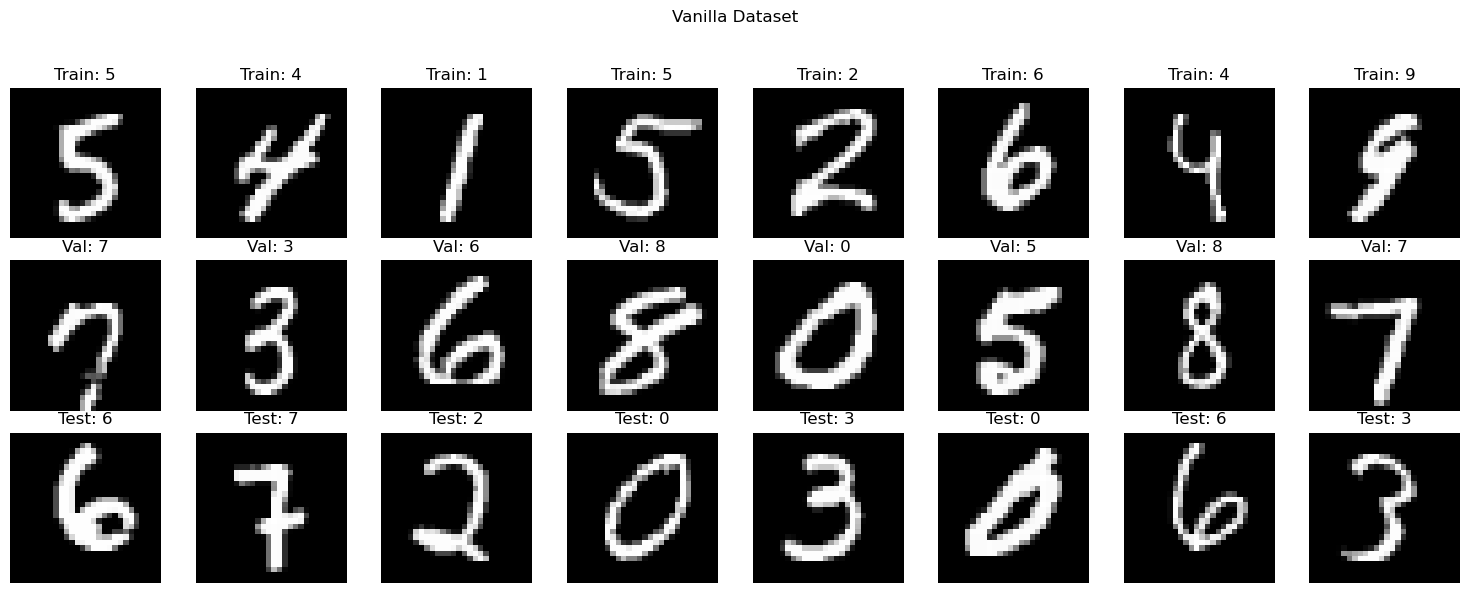

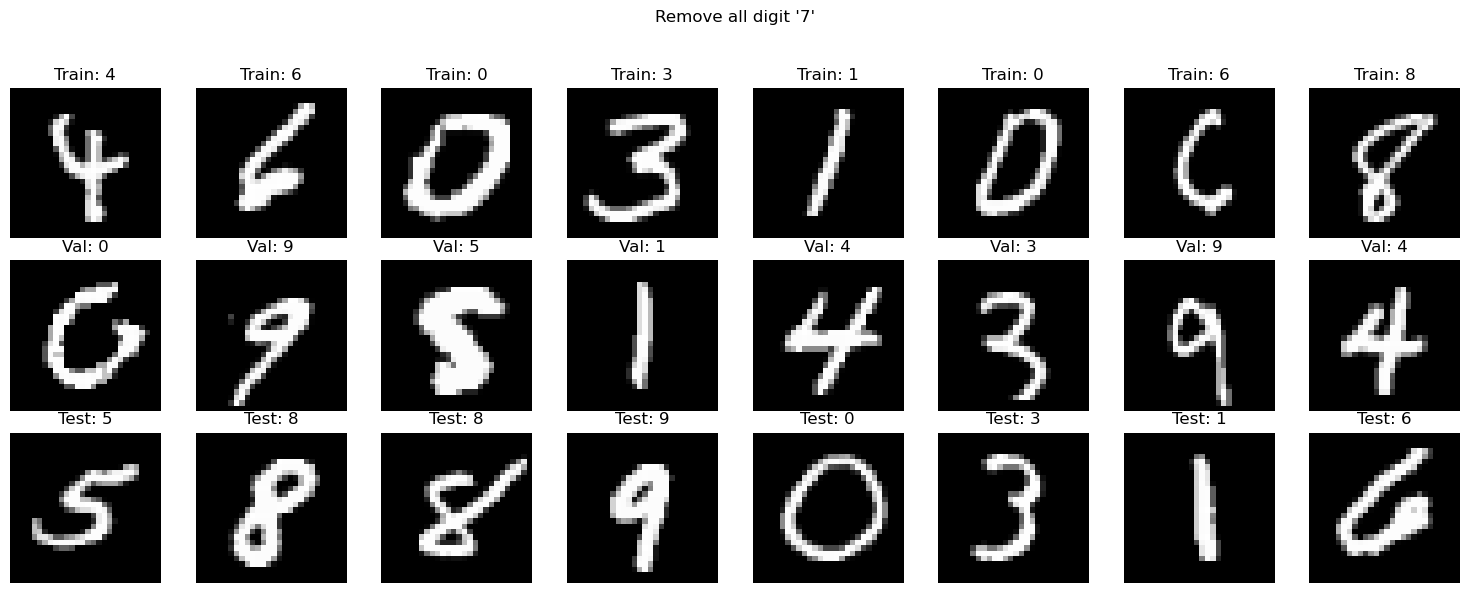

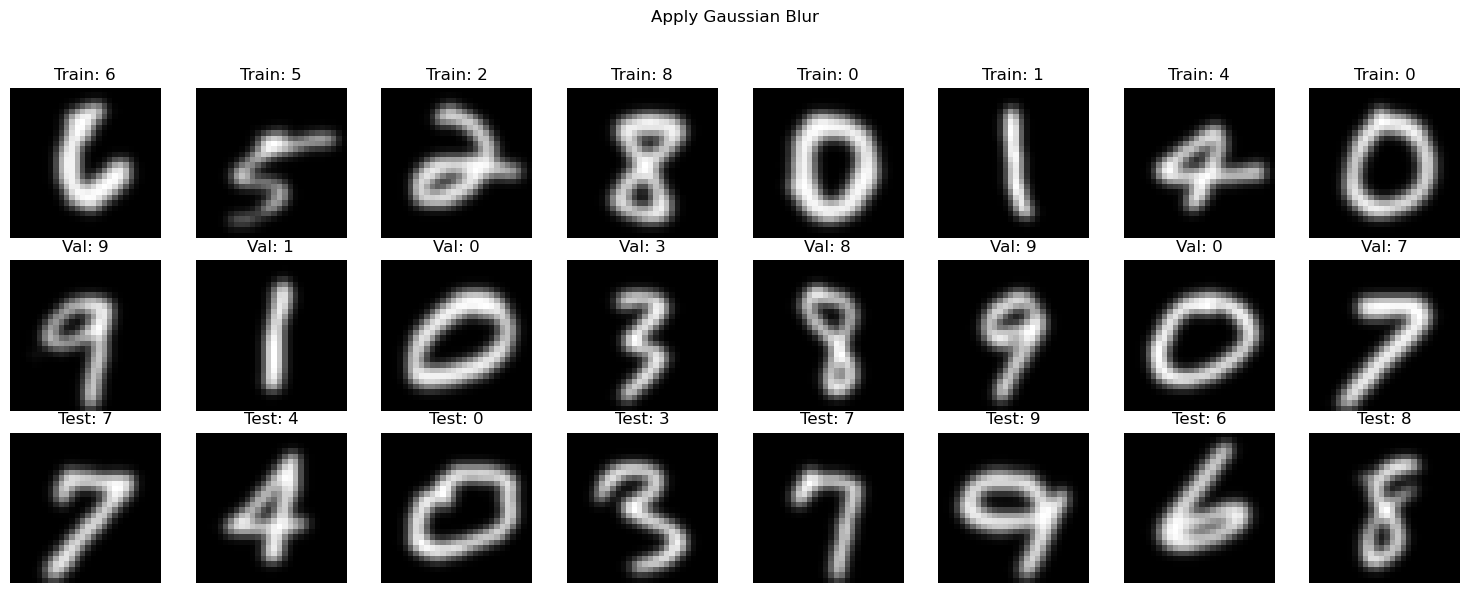

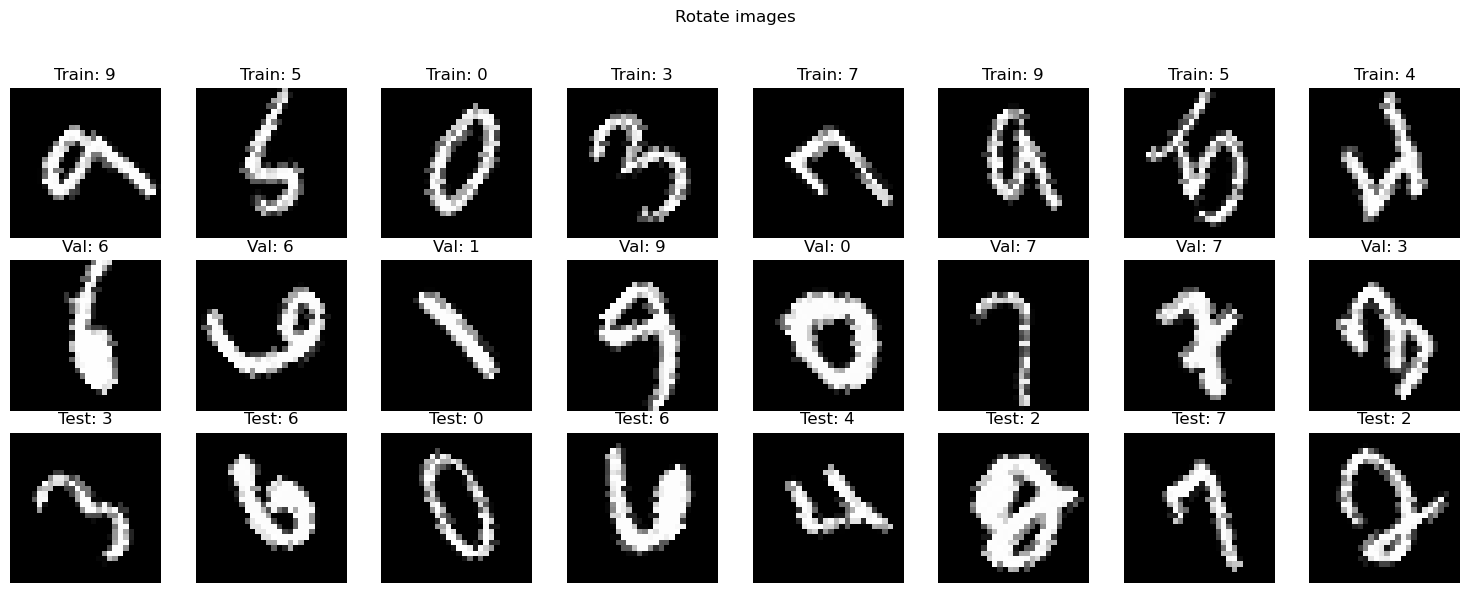

In [ ]:
title = ["Vanilla Dataset", "Remove all digit \'7\'", "Apply Gaussian Blur", "Rotate images"]

for client_idx, (train_loader, val_loader, test_loader) in enumerate(loaders):
    fig, axes = plt.subplots(3, 8, figsize=(15, 6))
    fig.suptitle(title[client_idx])
    
    # Train
    for j, (x, y) in enumerate(train_loader):
        if j >= 8:
            break
        axes[0, j].imshow(x[0].squeeze(), cmap='gray')
        axes[0, j].axis('off')
        axes[0, j].set_title(f"Train: {y[0].item()}")
    
    # Validation
    for j, (x, y) in enumerate(val_loader):
        if j >= 8:
            break
        axes[1, j].imshow(x[0].squeeze(), cmap='gray')
        axes[1, j].axis('off')
        axes[1, j].set_title(f"Val: {y[0].item()}")
    
    # Test
    for j, (x, y) in enumerate(test_loader):
        if j >= 8:
            break
        axes[2, j].imshow(x[0].squeeze(), cmap='gray')
        axes[2, j].axis('off')
        axes[2, j].set_title(f"Test: {y[0].item()}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [54]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [55]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader, id_):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id_

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"{self.id} accuracy: {float(accuracy)}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [56]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (MNIST)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = loaders[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader, partition_id).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [65]:

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    _, _, testloader = loaders[0]
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=4,  # Never sample less than 4 clients for training
    min_evaluate_clients=4,  # Never sample less than 4 clients for evaluation
    min_available_clients=4,  # Wait until all 4 clients are available
    evaluate_metrics_aggregation_fn=weighted_average, # metric aggregation function
    evaluate_fn=evaluate,  # Pass the evaluation function
)

In [66]:


def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

In [67]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [68]:
# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07220930202802023, {'accuracy': 0.096}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.07220930202802023 / accuracy 0.096


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.021622389862934747, {'accuracy': 0.7976666666666666}, 7.704422649000662)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.021622389862934747 / accuracy 0.7976666666666666
(ClientAppActor pid=41592) 0 accuracy: 0.7753333333333333
(ClientAppActor pid=41592) 1 accuracy: 0.8706319702602231
(ClientAppActor pid=41592) 2 accuracy: 0.7726666666666666


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=41592) 3 accuracy: 0.46266666666666667


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.007284685136129458, {'accuracy': 0.9313333333333333}, 16.9031772240005)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.007284685136129458 / accuracy 0.9313333333333333
(ClientAppActor pid=41592) 0 accuracy: 0.9353333333333333
(ClientAppActor pid=41592) 1 accuracy: 0.9434944237918216
(ClientAppActor pid=41592) 2 accuracy: 0.9253333333333333


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=41592) 3 accuracy: 0.6766666666666666


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.004922093898368379, {'accuracy': 0.95}, 26.026659322999876)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.004922093898368379 / accuracy 0.95
(ClientAppActor pid=41592) 0 accuracy: 0.9593333333333334
(ClientAppActor pid=41592) 1 accuracy: 0.9591078066914498
(ClientAppActor pid=41592) 2 accuracy: 0.9466666666666667


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=41592) 3 accuracy: 0.7506666666666667


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.003880599581946929, {'accuracy': 0.9613333333333334}, 35.01464799000041)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.003880599581946929 / accuracy 0.9613333333333334
(ClientAppActor pid=41592) 0 accuracy: 0.9673333333333334
(ClientAppActor pid=41592) 1 accuracy: 0.9643122676579926
(ClientAppActor pid=41592) 2 accuracy: 0.956


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=41592) 3 accuracy: 0.794


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.0035886684339493514, {'accuracy': 0.962}, 43.87690099300016)
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0035886684339493514 / accuracy 0.962
(ClientAppActor pid=41592) 0 accuracy: 0.9693333333333334
(ClientAppActor pid=41592) 1 accuracy: 0.971003717472119
(ClientAppActor pid=41592) 2 accuracy: 0.9613333333333334


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 45.60s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.029053555449145833
INFO :      		round 2: 0.013162514524389535
INFO :      		round 3: 0.009775856423700803
INFO :      		round 4: 0.007949435728311935
INFO :      		round 5: 0.00720757785494497
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07220930202802023
INFO :      		round 1: 0.021622389862934747
INFO :      		round 2: 0.007284685136129458
INFO :      		round 3: 0.004922093898368379
INFO :      		round 4: 0.003880599581946929
INFO :      		round 5: 0.0035886684339493514
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7170571089919724),
INFO :      	              (2, 0.8686137330962772),
INFO :      	              (3, 0.902744396853618),
INFO :      	              (4, 0.9194570335650019),
INFO :      	           

(ClientAppActor pid=41592) 3 accuracy: 0.8146666666666667
